---
layout: default
mathjax: true
---

## Sentinel-2 Vessel Semantic Segmentation  
---

### Background

This is my first all-around ML project. It probably wasn't the best choice for a starter, but I like to get my hands dirty and this is a project that I have worked on in the past, but without the ML aspect.

I started off by trying my luck with Random Forests and XGBoosting, both of which gave me some nice results. The problem at the time was the data conditioning, which I wasn't doing sufficiently well.

After that, I decided to try my luck with Deep Learning and I already knew about the capabilities of the UNET architecture for semantic segmentation. I used a read-made model which I found on github, and that was basically my starting point. After a lot of failures, some of which took less and some took more time, I finally gained a better understanding of what was and what wasn't working to my benefit.

As with many Deep Learning projects, I have now come to a halt because the data is insufficient to achieve increased accuracy. The model performs adequately, but there's definitely room for improvements. Unfortunately, a lack of free time keeps me from creating more data (which is a painfully slow and tedious task!).

This model was trained on about 1787 positive samples and 615 negative samples. The biggest issue I faced was class imbalance. It's easy to observe that the number of pixels in a Sentinel-2 scene (10980x10980 pixels) that correspond to vessels at any given time, are very small compared to the whole scene. As a matter of fact the exact number of pixels in each class are shown in the following table:

| Class | Number of Samples (Tiles) | Number of Samples (Pixels) | Contribution (%) |
| :-----------: | :-----------: | :-----------: | :-----------: |
| 0 | 615 | 9,702,986 | 98.62 |
| 1 | 1787 | 135,606 | 1.38 |

The above table shows that the contribution of the positive class to the total number of samples is just about 1.4%, while the corresponding figure for the negative class is about 98.6%! This imbalance will skew the training metrics, which in turn affects the learning capabilities of the model.

### Model Architecture

As I mentioned before, I used the UNET architecture that utilizes CNNs, which is a very powerful architecture for semantic segmentation and it was proposed <sup>[1]</sup> for use in biomedical image segmentation. The UNET model comprises of a compression path (left-hand side of the image), that uses MaxPooling layers and compresses the image 16x by the time it reaches the bottom of the **_U_** , and an expansive path (right-hand side of the image), that upsamples the downsampled image 16x by the time it has reached the top-most layer. That way, the model gains the ability to effectively learn both the finer and the coarser details of the images.

![UNET](./assets/images/unet-architecture.png)

If you plan to implement this architecture, bear in mind that the input image size needs to be a power of 2, with the smaller size being that of 64x64 pixels.

[1]: https://arxiv.org/abs/1505.04597

<script src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML" type="text/javascript"></script>
### Data Augmentation, Loss Functions, Optimizers

#### Data Augmentation

When it comes to images, data augmentation techniques include, but are not limited to, scaling, shearing, rotations, mirroring, etc. In my case, I knew right off the bat that I didn't want to choose a data augmentation technique that would alter/resample my training data, as this would mean that the spectral information would be altered as well.

For this reason, I went with 3 rotations ($90^o$, $180^o$ and $270^o$) and 2 flips, 1 along the X-axis and 1 along the Y-axis. That way, no resampling needed to be used, thus maintaining the original information of the pixels.

#### Loss functions

For the loss function, I decided to look further that the `binary crossentropy loss` and utilize some function that's better suited for segmentation problems. Then, came the Jaccard Index, which led me to find a loss function implemented using the Dice coefficient. The Dice coefficient is given by: 

<div style="text-align: center">$D=\frac{2\times \sum_{i=1}^{n} p_i g_i}{\sum_{i=1}^{n} p_i^{2} + \sum_{i=1}^{n} g_i^{2}}=\frac{2\times Intersection}{Union},\\ where\ p_i: \ Prediction\ and\ g_i:\ Ground\ truth$</div>

This loss function gave me better results -considering the vast class imbalance- and subsequent skewness of the metrics.

#### Optimizers

Regarding the optimizer, I first went with Stochastic Gradient Descent with Nesterov momentum enabled, because I thought that if I could get the parameters right, I would get really good results. I quickly found out that this wasn't the case, and I believe that the class imbalance had a significant effect to that end. Then, I turned to using the Adam optimizer, which needed no tuning to start giving me some legit results.

### Data

The Sentinel-2 satellites offer 13 bands in total at spatial resolution ranging from 10m to 60m. Sentinel-2 currently offer 2 levels of data, Level 1C and Level 2A. In this project, I used L1C products. Spatial resolution is a deciding factor -since if I selected the coarser bands the model wouldn't be able to detect small vessels-, but so is the spectral information. For this project, I decided that the bands which would give me a good trade-off between spectral information and spatial resolution are the ones shown in the table below:

| Band | Central Wavelength (nm) | Spatial Resolution (m) | Used |
| :----------- | :-----------: | :-----------: | :-----------: | 
| B01 - Coastal Aerosol | 492.3 | 60 | &#9746; |
| B02 - Blue | 492.3 | 10 | &#9745; |
| B03 - Green | 559.4 | 10 | &#9745; |
| B04 - Red | 664.8 | 10 | &#9745; |
| B05 - Vegetation red edge | 704.0 | 20 | &#9746; |
| B06 - Vegetation red edge | 739.9 | 20 | &#9746; |
| B07 - Vegetation red edge | 781.3 | 20 | &#9746; |
| B08 - NIR | 832.8 | 10 | &#9745; |
| B8A - Narrow NIR | 864.4 | 20 | &#9745; |
| B09 - Water vapour | 944.1 | 60 | &#9746; |
| B10 - SWIR Cirrus | 1375.2 | 60 | &#9746; |
| B11 - SWIR-1 | 1612.1 | 20 | &#9745; |
| B12 - SWIR-2 | 2194.1 | 20 | &#9745; |

I discarded all the bands with 60m pixel size, because I needed to be able to detect smaller vessels (e.g. leisure or fishing boats), as well as large container vessels, and the 60m would probably decrease my chance to achieve it. Similarly, if I decided to use only the 10m bands (Blue, Green, Red, NIR), I would have the advantage of higher spatial resolution, but I would lose all the information in the other 3 bands, which are also captured in distinct and non-overlapping parts of the light spectrum.

### Data Exploration

To gain a better understanding of the data, I plotted distribution and violin plots for both classes and for each band.

Distribution Plot | Violin Plot
:-:|:-:
![B02 distribution](./assets/images/B02_distribution.png) | ![B02 violin](./assets/images/B02_violin.png)
![B03 distribution](./assets/images/B03_distribution.png) | ![B03 violin](./assets/images/B03_violin.png)
![B04 distribution](./assets/images/B04_distribution.png) | ![B04 violin](./assets/images/B04_violin.png)
![B08 distribution](./assets/images/B08_distribution.png) | ![B08 violin](./assets/images/B08_violin.png)
![B08A distribution](./assets/images/B8A_distribution.png) | ![B8A violin](./assets/images/B8A_violin.png)
![B11 distribution](./assets/images/B11_distribution.png) | ![B11 violin](./assets/images/B11_violin.png)
![B12 distribution](./assets/images/B12_distribution.png) | ![B12 violin](./assets/images/B12_violin.png)

From these plots we can see that in certain cases (B02, B03), there is some spectral overlap between the two classes. This means that vessels and non-vessels can be detected in similar reflectance value ranges, which calls for a highly non-linear approach, perfectly suited for Deep Learning.

---

This Notebook, along with the model, can be found in [this](https://github.com/nargyrop/sentinel-2-unet.git) repo.
Feel free to download a Sentinel-2 scene and try it yourself!

---

### The fun part

Let's start by importing all the necessary modules. The `pyna` module is a library of functions I have created.

In [1]:
%matplotlib notebook
import warnings
warnings.simplefilter(action='ignore', category=(DeprecationWarning, FutureWarning))

import os
import cv2
import pickle
import xmltodict
import tensorflow as tf
from tensorflow.keras.models import model_from_json
import folium
import numpy as np
import matplotlib.pyplot as plt
from pyna.rasterlib import Raster
from pyproj import Proj, transform
from IPython.display import HTML
from ipywidgets import *

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
def reproject_coordinates(coord_list, epsg_in):
    """
    Function to reproject coordinate tuples to a target CRS using its EPSG code.
    """
    
    in_proj = Proj(init=f"epsg:{epsg_in}")
    out_proj = Proj(init="epsg:4326")
    
    # To store list of transformed coordinates
    coord_transf = []
    
    for coord in coord_list:
        coord_transf.append(transform(in_proj,out_proj,coord[0],coord[1]))
    
    return coord_transf

In [3]:
def get_model_parameters(xml_dir, xml_fname):
    """
    Function to load model weights and preprocessing parameters.
    """
    with open(os.path.join(xml_dir, xml_fname)) as fd:
        doc = xmltodict.parse(fd.read())
    
    # Not all of the bands might be needed. This is also specified on the filename.
    bands = list(map(int, doc['training_parameters']['bands'].split(',')))
    ndvi_cr = doc['training_parameters']['ndvi']
    
    ndvi_cr = 'True' == True
    
    padding = int(doc['training_parameters']['padding'])
    max_vals = list(map(float, doc['training_parameters']['max_values'].split(',')))  # For normalization

    return bands, ndvi_cr, padding, max_vals

In [4]:
def update():
    """This is needed to update the matplotlib plots"""
    fig.canvas.draw_idle()

In [5]:
ro = Raster()  # Instance of my rasterlib library

This is were I'll initialize some required variables, for example the location of files and the required bands.

In [3]:
ziploc = "/home/nikos/Downloads/S2A_MSIL1C_20200525T100031_N0209_R122_T33TUL_20200525T120308.zip"  # target zip file
req_bands = ("B02", "B03", "B04", "B08", "B8A", "B11", "B12")  # required bands
file_extn = "jp2"  # raster extension
pixel_size = 10  # target pixel size

xml_mod_dir = './trained_model'  # Directory were the model is stored
xml_fname = 'unet_2020-03-30_11-00_12345.xml'  # XML that includes preprocessing parameters
model_fname = xml_fname.replace('xml', 'json')  # Model
weights_fname = xml_fname.replace('xml', 'h5')  # Model weights

Then, all the required bands are loaded into arrays straight from the zip file. That way we're saving time and disk space. Along with the arrays, we'll get some more data, like the transformation tuple, the projection string and the EPSG code.

In [11]:
# Load required bands from S-2 zip file
band_dict = ro.load_from_zip(ziploc, req_bands, file_extn)
dict_keys = list(band_dict.keys())

Next, we'll make sure each band's pixel size is the same as the target one. For this model, we need 10m pixels. We'll also amend the transformation tuple of each band to match the correct pixel size.

In [12]:
# Resample all the bands to the target pixel size
for band in band_dict.keys():
    if band_dict[band][1][1] != pixel_size:
        band_dict[band][0] = ro.resample_array(band_dict[band][0],
                                               in_pix=band_dict[band][1][1],
                                               out_pix=pixel_size)
        transf = list(band_dict[band][1])
        transf[1] = pixel_size
        transf[-1] = -pixel_size
        band_dict[band][1] = tuple(transf)
transf = band_dict[dict_keys[0]][1]

Now that all the bands have matching pixel sizes, we'll stack them to a single array.

In [13]:
merged_arr = np.dstack([band_dict[band][0] for band in dict_keys])  # Stack all bands to a single array

Since the model required tiles of size (64, 64, 7 (bands)), we'll tile the stack. The output will be an array of shape (171, 171, 1, 64, 64, 7). This function utilizes a very nice and computationally efficient numpy function, called `stride_tricks`.

In [14]:
tiled_merged_arr = ro.get_tiles(merged_arr, ksize=64)

Before running the inference, we need to load the model and some preprocessing parameters (normalization values).

In [15]:
# Get model training parameters
band_list, ndvi_cr, padding, max_vals = get_model_parameters(xml_mod_dir, xml_fname)

# load json and create model
json_file = open(os.path.join(xml_mod_dir, model_fname), 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# load weights into new model
model.load_weights(os.path.join(xml_mod_dir, weights_fname))

Then, we'll preprocess the image and have it ready for inference.

In [16]:
if not tiled_merged_arr.shape[-1] + 1 * ndvi_cr == len(band_list):
    tiled_merged_arr = tiled_merged_arr[:, :, :, :, :, band_list]
tiled_merged_arr = np.squeeze(tiled_merged_arr)

# There is the option of also including the NDVI in the bands
if ndvi_cr:
    ndvi = np.divide(tiled_merged_arr[:, :, :, :, 3] - tiled_merged_arr[:, :, :, :, 2],
                     tiled_merged_arr[:, :, :, :, 3] + tiled_merged_arr[:, :, :, :, 2])
    ndvi = np.nan_to_num(ndvi[:, :, :, :, np.newaxis])
    tiled_merged_arr = np.concatenate([tiled_merged_arr, ndvi], axis=4)
    ndvi = None  # Remove from memory

# This is where the normalization happens
tiled_norm_arr = tiled_merged_arr.astype(np.float32)
for band in range(tiled_merged_arr.shape[-1]):
    tiled_norm_arr[:, :, :, :, band] /= max_vals[band]

# We can also apply some padding to each tile, in order to reduce edge effects
tiled_norm_pad = np.pad(tiled_norm_arr,
                        ((0, 0), (0, 0), (padding, padding), (padding, padding), (0, 0)), mode='symmetric')

Now we're ready to run the inference!

In [17]:
tiled_merged_arr, tiled_norm_arr = None, None  # Remove some variables from memory

# Get the number of tiles in each direction, tile size in each direction and number of bands
ntilesy, ntilesx, sy, sx, nbands = tiled_norm_pad.shape

# Reshape the array to stack all tiles along the y-axis
tiled_reshaped = tiled_norm_pad.reshape(ntilesy * ntilesx, sy + 2 * padding, sx + 2 * padding, nbands)
tiled_norm_pad = None  # You know what this does by now

# Run the inference
predictions = model.predict(tiled_reshaped)

# Remove the padding if it's been applied
if padding:
    predictions = predictions[:, padding:-padding, padding:-padding, :]

# Reshape back to match the original image
outsl_res = predictions.reshape(ntilesy, ntilesx, sy, sx)
out_arr = np.concatenate(np.concatenate(outsl_res, axis=1), axis=1)

predictions, outsl_res, tiled_reshaped, model = None, None, None, None

In [18]:
# Make inference mask 3D and add alpha channel. Positives will have red colour
alpha_ch = np.zeros_like(out_arr)
alpha_ch[out_arr > 0.5] = 255  # We'll make transparent all the pixels with less than 50% probability
out_arr = np.dstack((out_arr * 255, np.zeros_like(out_arr), out_arr, alpha_ch)).astype(np.uint8)

In [20]:
np.save(ziploc.replace('zip', 'npy'), out_arr)

Now that the inference is done, we'll display the mask against the RGB image. The Sentinel-2 images are 16-bits. In order to correctly display them with Folium, we'll convert them to 8-bits.

In [21]:
rgb_arr = ro.rgb16to8(merged_arr[:, :, [2, 1, 0]]).astype(np.uint8)
merged_arr = None

<IPython.core.display.Javascript object>


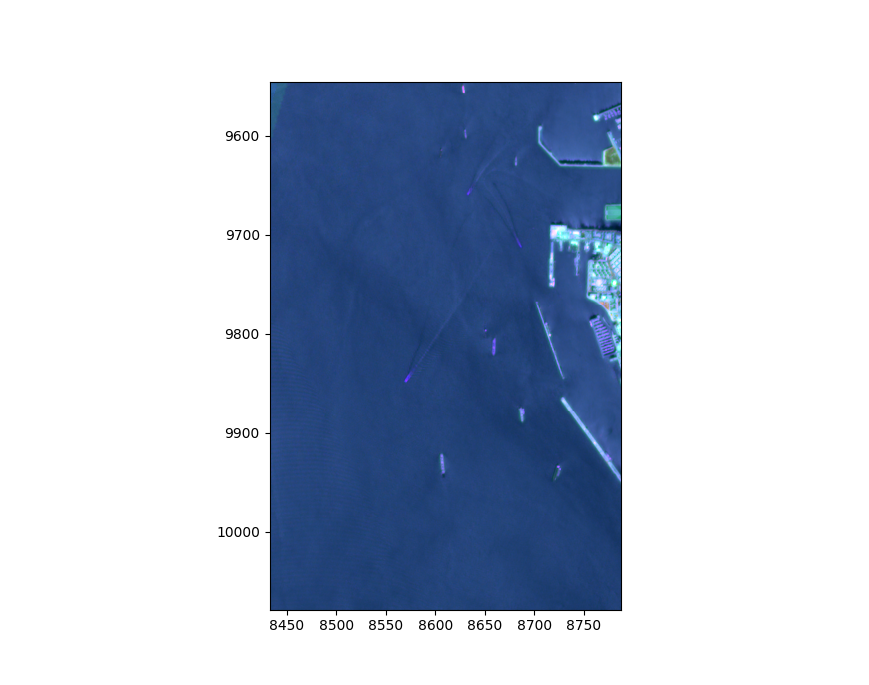

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(rgb_arr.astype(np.uint8), interpolation='none')
ax.imshow(out_arr.astype(np.uint8), 'gray', interpolation='none', alpha=0.7)
plt.show()
interact(update);

I'll downsample the RGB image and the mask to 20m, just because the map will be very big to load.

In [2]:
rgb_arr = ro.resample_array(rgb_arr, in_pix=10, out_pix=20)
out_arr = ro.resample_array(out_arr, in_pix=10, out_pix=20)

# The transformation tuple also needs to be adjusted
transf = list(transf)
transf[1] = 20
transf[5] = -20

NameError: name 'ro' is not defined

In [1]:
# Get the geographical extents for the RGB image
extents_ls_rgb = [(transf[0], transf[3] + rgb_arr.shape[0] * transf[5]),
                  (transf[0] + rgb_arr.shape[1] * transf[1], transf[3])]

# And for the inference mask
extents_ls_inf = [(transf[0], transf[3] + out_arr.shape[0] * transf[5]),
                  (transf[0] + out_arr.shape[1] * transf[1], transf[3])]

NameError: name 'transf' is not defined

In [17]:
epsg = band_dict[dict_keys[0]][3]  # get the EPSG from any of the bands that have been loaded

transformed_ls_rgb = reproject_coordinates(extents_ls_rgb, epsg)  # Convert RGB image extents to WGS84
min_lon_rgb, min_lat_rgb = transformed_ls_rgb[0]
max_lon_rgb, max_lat_rgb = transformed_ls_rgb[1]

transformed_ls_inf = reproject_coordinates(extents_ls_inf, epsg)  # Convert Inference mask extents to WGS84
min_lon_inf, min_lat_inf = transformed_ls_inf[0]
max_lon_inf, max_lat_inf = transformed_ls_inf[1]

We're almost done. We just need to create our map using Folium.

In [18]:
# Setup the map
inf_map = folium.Map(location=(np.mean([min_lat_rgb, max_lat_rgb]),
                               np.mean([min_lon_rgb, max_lon_rgb])),
                     width=640,
                     height=480,
                     zoom_start=8)
                     
# First display the RGB image
rgb_img = folium.raster_layers.ImageOverlay(
                                            name='Image',
                                            image=rgb_arr,
                                            bounds=[[min_lat_rgb, min_lon_rgb],
                                                    [max_lat_rgb, max_lon_rgb]],
                                            opacity=1,
                                            interactive=True,
                                            cross_origin=False,
                                            zindex=1,
                                            )

# Then, display the inference mask
mask_img = folium.raster_layers.ImageOverlay(
                                             name='Inference Mask',
                                             image=out_arr,
                                             bounds=[[min_lat_inf, min_lon_inf],
                                                     [max_lat_inf, max_lon_inf]],
                                             opacity=0.6,
                                             interactive=True,
                                             cross_origin=False,
                                             zindex=1,
                                             )

# Add both to the map
rgb_img.add_to(inf_map)
mask_img.add_to(inf_map)

# And also add LayerControl so that either can be turned on and off
_ = folium.LayerControl().add_to(inf_map)

In [1]:
inf_map.save("test_map.html")  # save to html in order to display it on a webpage

NameError: name 'inf_map' is not defined

And last, but not least...

In [2]:
HTML(filename="test_map.html")

NameError: name 'HTML' is not defined

In [20]:
# Uncomment the following line to view map in jupyter notebook
# inf_map